# This is the file used for the Initial Development Phase

## 1. Initial Setup and Library Imports

Importing all necessary libraries and setting up the environment for our analysis.

In [26]:
# --- Core Data Manipulation and NLP ---
import pandas as pd
import nltk
import os
import requests
#nltk.download('vader_lexicon')
from nltk.tokenize import sent_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# --- Data Visualization ---
import matplotlib.pyplot as plt

# --- Web Framework ---
from flask import Flask, render_template, request
import pandas as pd
#nltk.download('punkt_tab')


# 2. AFINN/Lexicon Loading
### Function to read and parse the AFINN lexicon, then loads it into a dictionary (afinn_dict)

In [27]:
'''
2. AFINN/Lexicon Loading
Function to read and parse the AFINN lexicon, then loads it into a dictionary (afinn_dict)
'''
def load_afinn_lexicon(afinn_path):
    afinn_dict = {} # initialise an empty dictionary to hold the AFINN lexicon
    try:
        with open(afinn_path, encoding='utf-8') as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                word, score = line.rsplit('\t', 1)
                afinn_dict[word] = int(score)
    except FileNotFoundError:
        print(f"File not found: {afinn_path}")
    return afinn_dict


### Load the AFINN lexicon (provided sentiment dictionary) then print a sample of it

In [28]:
'''
Load the AFINN lexicon (provided sentiment dictionary) 
'''

afinn_path = "data/AFINN-en-165.txt"
afinn_dict = load_afinn_lexicon(afinn_path)

# print("AFINN dictionary loaded. Sample entries:")
# print(list(afinn_dict.items())[:10])  # show first 10 words and scores


# 3. Data Loading & Cleaning

Declare variable for sentiment analysis

Load dataset from github 

List special characters to be removed from dataset.

In [29]:
'''
3. Data Loading & Cleaning
'''
sid = SentimentIntensityAnalyzer()


# Load data
url = 'https://raw.githubusercontent.com/DyanelLancea/Airline-Review-Sentiement-Analysis/refs/heads/master/data/airlines_review.csv'
df = pd.read_csv(url)

# List of special characters to remove
removechar = [ '@', '#', '$', '%', '^', '&', '*', '(', ')',
               '-', '_', '=', '+', '{', '}', '[', ']', '|',
               '\\', ':', ';', '"', "'", '<', '>', '?',
                 '/', '~', '`', '✅ Trip Verified', 'Not Verified', 'Â Â', '✅ Verified Review']


Remove duplicates from dataset

Drop rows of data that have missing values

Replace mssing values with "NA" or "Unknown" if required

Function to remove sepcial characters from required column of data and tidy up for analysis

In [30]:

# Remove duplicates
df = df.drop_duplicates()
# Remove rows with missing values
df = df.dropna()

# Replace missing values with NA or Unknown function
def replace_missing_value(df):
    for col in df.columns:
        if df[col].dtype == 'O':  # Object type (string)
            df[col] = df[col].fillna('Unknown')
        else:
            df[col] = df[col].fillna("NA")
    return 

# Remove special characters from specific columns function
def remove_special_characters(df, removechar, char):
    for char in removechar:
        df['Airlines'] = df['Airlines'].str.replace(char, ' ', regex=False)
        df['Text Content'] = df['Text Content'].str.replace(char, '', regex=False)
    return df


Apply function replace missing values and remove speical characters

Standardize text case for analysis and make text lower case for analyzation

Remove unwanted leading spaces from all data column to make it neat and tidy

In [31]:

# Apply data cleaning functions
replace_missing_value(df)
remove_special_characters(df, removechar, char='')

# Standardize text case
df['Airlines'] = df['Airlines'].str.title()
df['Name'] = df['Name'].str.title()
df['Text Content Lower Case'] = df['Text Content'].str.lower()

# Remove leading spaces from the 'Name' column
df['Airlines'] = df['Airlines'].str.lstrip()
df['Name'] = df['Name'].str.lstrip()
df['Date Published'] = df['Date Published'].str.lstrip()
df['Text Content'] = df['Text Content'].str.lstrip()



## Word Segmentation functions

In [32]:
''' This is under Requirement 6 of the project '''

def load_dictionary(dict_path):
    '''
    Load words.txt into a set for O(1) membership tests.
    Normalize to lowercase.
    '''
    words = set()
    with open(dict_path, 'r', encoding='utf-8', errors='ignore') as f:  
        # use ignore to skip bad chars, 'open(..) as f' is to auto close when done
        for line in f:
            w = line.strip() # strip whitespace/newline
            if not w:
                continue
            words.add(w.lower()) # store lowercase for matching
    return words

# Core DP segmentation function
def segment_text(text, dictionary, max_word_length=30, unknown_penalty=1):
    '''
    Segment `text` (string without spaces) into words using dictionary.
    Returns a segmented string (have spaces). Keeps original casing of input,
    but algorithm works on lowercase.
    
    - max_word_length: limit to consider for last word length (speeds up).
    - unknown_penalty: penalty (cost) for each character that is not matched to a dictionary word.
    
    Strategy:
      DP over positions. best[i] = (score, last_split_index)
      Score is total matched characters (so higher is better). Unknown chars are penalized.
    '''
    if text is None:
        return ""
    s = text.strip()
    if not s:
        return ""
    
    s_lower = s.lower() #converts whole input string lowercase for matching
    n = len(s_lower)
    best_score = [-10**9] * (n + 1) # best score so far, ending position i
    prev_idx = [-1] * (n + 1)   # records where last word started, for backtracking
    best_score[0] = 0  # empty prefix score 0
    max_len = min(max_word_length, n)  # for speed, precompute maximum possible word length (min of provided max and n)
    length_bias = 0.3  # bias towards longer words
    
    
    
    for i in range(1, n + 1):       
        start_j = max(0, i - max_len)
        # loops through each position i
        
        for j in range(start_j, i):
            #checks for best segmentation up to j within max_len
            chunk = s_lower[j:i]
            L = len(chunk)

            if chunk in dictionary:
                # reward/score: matched characters count, with extra bonus for longer words
                # base = L ; multiplier increases with length_bias
                multiplier = 1.0 + length_bias * (L - 1)
                score = best_score[j] + (L * multiplier)
            else:
                # penalise unknown chunk by its length * penalty
                score = best_score[j] - (L * unknown_penalty)

            if score > best_score[i]:
                best_score[i] = score
                prev_idx[i] = j

    # reconstruct segmentation
    if prev_idx[n] == -1:
        # fallback: no segmentation found, return original
        return s

    tokens = []
    i = n #start from the end of the string
    while i > 0:
        j = prev_idx[i]
        if j == -1:
            # if something odd, push the remainder and break
            tokens.append(s[j:i])
            break
        tokens.append(s[j:i])
        i = j
    tokens.reverse()
    # Optionally, try to recover original casing by mapping tokens back to original text slice
    # We'll return tokens joined by spaces
    return ' '.join(tokens) #joins them all in a single string




In [33]:
def call_dynamic_prog():
    '''Call and use this func  when you are presenting req 6'''
     # Example: load dictionary and apply
    dict_path = os.path.join('data', 'words.txt')   # adjust path if your words.txt is elsewhere
    dictionary = load_dictionary(dict_path)         # uses words.txt you uploaded. :contentReference[oaicite:2]{index=2}

    # Optional: determine a reasonable max_word_length from the dictionary (speeds DP)
    if dictionary:
        max_word_length = max(len(w) for w in dictionary)
        # clamp to a reasonable upper bound (e.g., 30) for performance
        max_word_length = min(max_word_length, 30)
    else:
        max_word_length = 30

    # Add segmented column to your dataframe
    # Assuming df['Text Content'] contains the no-space strings

    df['Text Content Segmented'] = df['Text Content'].astype(str).apply(
        lambda t: segment_text(t, dictionary, max_word_length=max_word_length, unknown_penalty=1)
    )

    # Save a quick sample to inspect
    df[['Text Content', 'Text Content Segmented']].head(20).to_csv('segmentation_sample.csv', index=False)

    # (Then you can use 'Text Content Segmented' for later sentence tokenization or sentiment)

Export cleaned data to "airlines_review_cleaned.csv" for analyzation function

In [34]:
# Save cleaned data to a new CSV file
df.to_csv('data/vairlines_review_cleaned.csv', index=False)

# Display the cleaned DataFrame
#print(df)

## 4. Core Analysis Functions
### Function for Sentence tokanization 
This function takes some text and returns a list of sentences. If you don’t give it a string, it safely returns an empty list instead of crashing.

In [35]:
def tokenize_sentences(text):
    '''
    Function for Sentence tokanization. This function takes some text and returns a list of sentences. 
    If you don’t give it a string, it safely returns an empty list instead of crashing.
    '''
    if not isinstance(text, str):
        return []
    return sent_tokenize(text)

### Function to calculate sentiment and normalization

In [36]:
def calculate_sentiment_score(sentences, afinn_dict):
    '''
    Calculates the sentiment score
    '''
    score = 0
    words = sentences.lower().split()    # breaks down the sentence into individual words
    for word in words:  # goes through each word in the list 
        score += afinn_dict.get(word, 0)    # looks up each word and adds the score
    return score

def normalize_score(score, text_length):
    '''
    Calculates the normalization score
    '''
    if text_length == 0:    # sentences with no words will return a score of 0 (preventing an error of dividing by zero)
        return 0
    # normalization to get a score per word, then clamping to [-1, 1]
    normalized = score / text_length    # calculates the average score per word
    return max(-1.0, min(1.0, normalized))  
    # makes sure the score doesn't go over 1.0 and below -1.0. 
    # (if the score is -2.5, this will return -1.0)

### Function to find the extreme sentences

In [37]:
def find_extreme_sentences(sentences, afinn_dict):
    '''
    Finds extreme sentences with highest and lowest normalized sentiment scores
    1. Calculates sentiment scores for each sentence using the AFINN lexicon.
    2. Normalizes the sentiment scores based on sentence length.
    3. Identifies and returns the sentences with the highest and lowest normalized scores.
    '''
    
    if not sentences:   # to prevent errors if the list is empty
        return None, None

    # initialises an empty list to hold sentences and their scores
    scored_sentences = []
    for sent in sentences:
        score = calculate_sentiment_score(sent, afinn_dict)     # uses the sentiment score function
        normalized_score = normalize_score(score, len(sent.split()))    # uses the normalization function
        scored_sentences.append({'sentence': sent, 'score': normalized_score})

    # find the sentences with max and min normalized scores
    most_positive = max(scored_sentences, key=lambda x: x['score'])
    most_negative = min(scored_sentences, key=lambda x: x['score'])
    
    return most_positive, most_negative

### Sliding Window Function to find the most positive and negative paragraphs.

Using a window size lets us "slide" a focus area over the text. The window's score changes as it moves, so it can detect specific pockets of strong emotion(positive/negative).

When the window is over a section with very positive sentences, it will get a high score. When it slides over the negative section, it will get a very low score.

This give us a much more detailed and accurate picture of the sentiment throughout the text. It helps us pinpoint exactly where the most positive and negative opinions are located, rather than just getting a single, overall average.

In [38]:
def sliding_window_analysis_words(text, afinn_dict, window_size=10):
    """
    Applies a sliding window to find the most positive and negative text segments,
    based on a word-level window size.
    
    Args:
        text (str): The full text to analyze.
        afinn_dict (dict): The AFINN sentiment lexicon.
        window_size (int): The number of words to include in each window.

    Returns:
        tuple: A tuple containing the most positive and most negative paragraphs.
    """
    if not text:
        return None, None
        
    words = text.lower().split()
    if len(words) < window_size:
        return None, None
    
    scored_windows = []
    # Slide the window across the words
    for i in range(len(words) - window_size + 1):
        window = words[i:i + window_size]
        paragraph_text = ' '.join(window)
        
        # Calculate score for the paragraph window
        score = calculate_sentiment_score(paragraph_text, afinn_dict)
        normalized_score = normalize_score(score, len(paragraph_text.split()))

        scored_windows.append({'paragraph': paragraph_text, 'score': normalized_score})

    if not scored_windows:
        return None, None

    # Find the paragraphs with max and min scores
    most_positive_paragraph = max(scored_windows, key=lambda x: x['score'])
    most_negative_paragraph = min(scored_windows, key=lambda x: x['score'])
    
    return most_positive_paragraph, most_negative_paragraph



# 5. Apply Analysis to DataFrame

In [39]:
'''
Apply Analysis to DataFrame
'''
#Apply tonkenize function into Dataframe
df['Text Content Tokenized'] = df['Text Content'].apply(tokenize_sentences)

#Apply Sentiment scoring function into Dataframe
df['Sentiment Score'] = df.apply(lambda x: calculate_sentiment_score(x['Text Content'],afinn_dict), axis=1)

#Apply normalize function to Dataframe
df['Normalized Sentiment Score'] = df.apply(lambda x: normalize_score(x['Sentiment Score'],len(x["Text Content"].split())), axis=1)

#Apply finding extreme sentences function to Dataframe
df['Extreme Senctences'] = df.apply(lambda x: find_extreme_sentences(x['Text Content Tokenized'],afinn_dict), axis=1)

#Creating Columns for Most and Least Extreme Sentences
# df['Most Positive Senctence'] = df['Extreme Senctences'].apply(lambda x: x[0]['sentence'])
# df['Most Positive Senctence Score'] = df['Extreme Senctences'].apply(lambda x: x[0]['score'])
# df['Most Negative Senctence'] = df['Extreme Senctences'].apply(lambda x: x[1]['sentence'])
# df['Most Negative Senctence Score'] = df['Extreme Senctences'].apply(lambda x: x[1]['score'])

#Creating Columns for Most and Least Extreme Sentences with checks
df['Most Positive Senctence'] = df['Extreme Senctences'].apply(
    lambda x: x[0]['sentence'] if x and isinstance(x, tuple) and x[0] is not None else None)
df['Most Positive Senctence Score'] = df['Extreme Senctences'].apply(
    lambda x: x[0]['score'] if x and isinstance(x, tuple) and x[0] is not None else None)
df['Most Negative Senctence'] = df['Extreme Senctences'].apply(
    lambda x: x[1]['sentence'] if x and isinstance(x, tuple) and x[1] is not None else None)
df['Most Negative Senctence Score'] = df['Extreme Senctences'].apply(
    lambda x: x[1]['score'] if x and isinstance(x, tuple) and x[1] is not None else None)


#Applying Sliding Window to Dataframe
df['Sliding Window Results'] = df.apply(lambda x: sliding_window_analysis_words(x['Text Content'],afinn_dict, window_size=10), axis=1)


'''
Use this if you are testing with 'airlines_review_no_space.csv
'''
#Creating Columns for Most Positive and Negative lines of words from sliding window analysis
# df['Most Positive Line'] = df['Sliding Window Results'].apply(
#     lambda x: x[0]['sentence'] if x and isinstance(x, tuple) and x[0] is not None else None)
# df['Most Positive Line Score'] = df['Sliding Window Results'].apply(
#     lambda x: x[0]['sentence'] if x and isinstance(x, tuple) and x[0] is not None else None)
# df['Most Negative Line'] = df['Sliding Window Results'].apply(
#     lambda x: x[0]['sentence'] if x and isinstance(x, tuple) and x[0] is not None else None)
# df['Most Negative Line Score'] = df['Sliding Window Results'].apply(
#     lambda x: x[0]['sentence'] if x and isinstance(x, tuple) and x[0] is not None else None)

#Creating Columns for Most Positive and Negative lines of words from sliding window analysis
df['Most Positive Line'] = df['Sliding Window Results'].apply(lambda x: x[0]['paragraph'])
df['Most Positive Line Score'] = df['Sliding Window Results'].apply(lambda x: x[0]['score'])
df['Most Negative Line'] = df['Sliding Window Results'].apply(lambda x: x[1]['paragraph'])
df['Most Negative Line Score'] = df['Sliding Window Results'].apply(lambda x: x[1]['score'])


#Output results into csv
df.to_csv('data/airlines_review_analysis.csv', index=False)


# 6. Evaluation Functions & Application
Model Evaulation: We shall be evaluating our sentiment analysis based on 4 metrics Accuracy, Precision, Recall and F1 Score.


In [40]:
'''
Evaluation Functions & Application
Model Evaulation: We shall be evaluating our sentiment analysis based on 4 metrics Accuracy, 
Precision, Recall and F1 Score.
'''
#Function to convert our analysis scores from numbers to postive or negative
def score_postive_negative(score):
    if score < -0:
        return "Negative"
    elif score >= 0:
        return "Postive"
    
#Function to chnage airline review ratings to postive or negative
def rating_postive_negative(rating):
    if rating <= 5:
        return "Negative"
    elif rating >= 6:
        return "Postive"

#Funtion to check if your analysis is True or False 
def determine_correct_prediction(actual, pred):
    if actual == pred:
        return True
    else:
        return False
    
#Function to calculate accuracy
def calculate_aaccuracy(whether_correct_pred):
    return sum(whether_correct_pred)/len(whether_correct_pred)

#Funtion to calculate confusion matrix
def calculate_confusion_matrix(actual, pred):
    if actual == 'Postive' and pred == 'Postive':
        return 'TP'
    elif actual == 'Negative' and pred == 'Postive':
        return 'FP'
    elif actual == 'Negative' and pred == 'Negative':
        return 'TN'
    elif actual == 'Postive' and pred == 'Negative':
        return 'FN'

#Function to calculate precision
def calculate_precision(confusion_matric):
    return confusion_matric.count('TP')/(confusion_matric.count('TP')+confusion_matric.count('FP'))

#Funtion to calculate Recall
def calculate_recall(confusion_matric):
    return confusion_matric.count('TP')/(confusion_matric.count('TP')+confusion_matric.count('FN'))

#Applying the all the functions to our datafraame
df['score_postive_negative'] = df.apply(lambda x: score_postive_negative(x['Normalized Sentiment Score']), axis=1)
df['rating_postive_negative'] = df.apply(lambda x: rating_postive_negative(x['Rating']), axis=1)
df['whether_correct_pred'] = df.apply(lambda x: determine_correct_prediction(x['rating_postive_negative'],x["score_postive_negative"]), axis=1)
df['confusion_matrix'] = df.apply(lambda x: calculate_confusion_matrix(x['rating_postive_negative'],x["score_postive_negative"]), axis=1)
recall = calculate_recall(df['confusion_matrix'].tolist())
precision = calculate_precision(df['confusion_matrix'].tolist())

#Funtion to Calculate F1 Score
def calculate_F1score(precision,recall):
    return 2 * (precision * recall) / (precision + recall)

#Print out the results
print('Accuracy of Sentiment Analysis is',calculate_aaccuracy(df['whether_correct_pred']))
print(f'Precision of Sentiment Analysis is {precision}')
print(f'Recall of Sentiment Analysis is {recall}')
print('F1 Score of Sentiment Analysis is',calculate_F1score(precision,recall))

Accuracy of Sentiment Analysis is 0.8044812133746984
Precision of Sentiment Analysis is 0.7771851851851852
Recall of Sentiment Analysis is 0.9313528228192686
F1 Score of Sentiment Analysis is 0.8473134489070744


Usually, sentiment classification of accuracy between 80 to 85% is a good benchmark. Therefore, we can say our analysis just about hits thaat mark at 80.4%. However, accuracy may not be the most aaccurate metric to test our analysis as it can be misledding for uneven datasets.

With a precision of 77.7%, the model correctly identified most of the reviews it labeled as positive. However, this also indicates that a small proportion of negative reviews were incorrectly predicted as positive which may be lead to some airlines getting better reviews than expected.

The recall score of 93.1% demonstrates that the model successfully identified the vast majority of actual positive reviews and would allow us to tell if the airline is truly good based on the reviews.

The F1 score of 84.7% provides a balanced measure of performance, reflecting the model’s ability to maintain both high recall and reasonable precision.


### Insights into our results

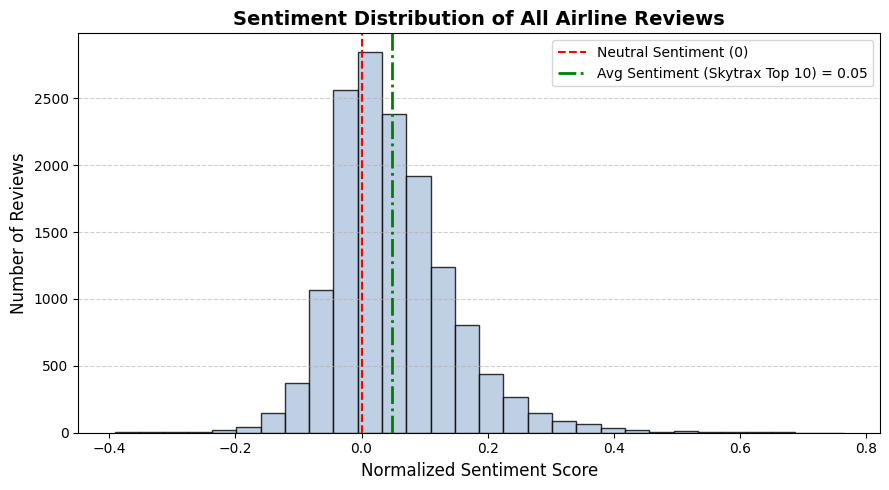

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

# Load processed dataset
df = pd.read_csv("data/airlines_review_analysis.csv")

# Define the official Skytrax Top 10 (2025)
skytrax_top10 = [
    "Qatar Airways",
    "Singapore Airlines",
    "Cathay Pacific Airlines",
    "Emirates",
    "All Nippon Airways",
    "Turkish Airlines",
    "Korean Air",
    "Air France",
    "Japan Airlines",
    "Hainan Airlines",
]

# Filter valid sentiment values
sentiments = df["Normalized Sentiment Score"].dropna()

# Calculate average sentiment for Top 10 airlines
top10_sentiment = (
    df[df["Airlines"].isin(skytrax_top10)]["Normalized Sentiment Score"]
    .mean()
)

# --- Create Histogram ---
plt.figure(figsize=(9, 5))
plt.hist(
    sentiments, bins=30, color="lightsteelblue",
    edgecolor="black", alpha=0.8
)

# Reference lines
plt.axvline(0, color="red", linestyle="--", linewidth=1.5, label="Neutral Sentiment (0)")
plt.axvline(
    top10_sentiment, color="green", linestyle="-.", linewidth=2,
    label=f"Avg Sentiment (Skytrax Top 10) = {top10_sentiment:.2f}"
)

# Titles & labels
plt.title("Sentiment Distribution of All Airline Reviews", fontsize=14, fontweight="bold")
plt.xlabel("Normalized Sentiment Score", fontsize=12)
plt.ylabel("Number of Reviews", fontsize=12)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Optional save
plt.tight_layout()
plt.savefig("visualisations/01_sentiment_distribution_adjusted.png", dpi=150)

# Display
plt.show()

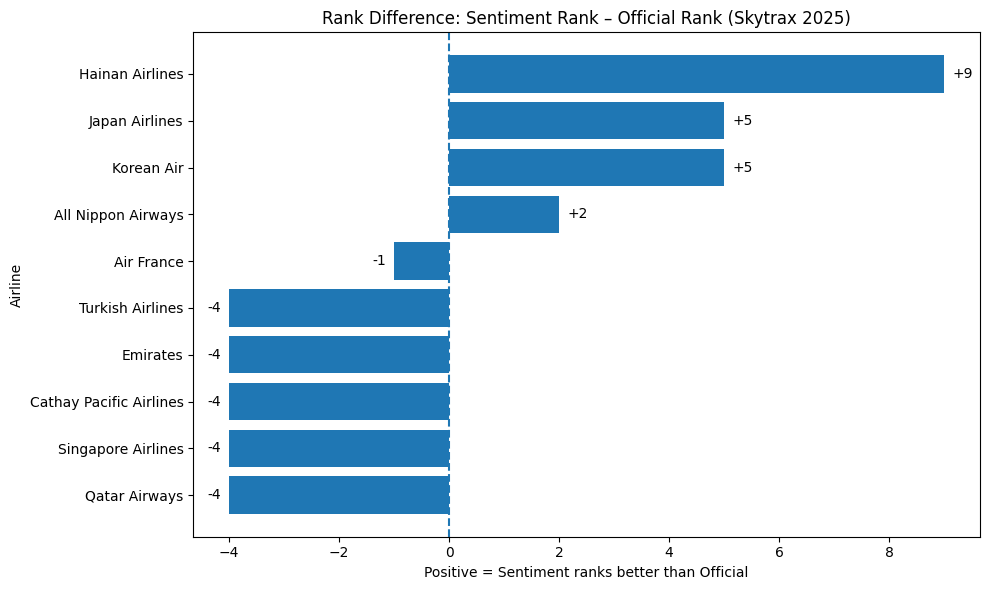

In [42]:
# --- Visual #2: Diverging Bar — Rank Difference (Sentiment Rank – Official Rank) ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) Load your processed reviews
df = pd.read_csv("data/airlines_review_analysis.csv")

# 2) Skytrax 2025 Top 10 (official order)
skytrax_top10 = [
    "Qatar Airways",
    "Singapore Airlines",
    "Cathay Pacific Airlines",
    "Emirates",
    "All Nippon Airways",
    "Turkish Airlines",
    "Korean Air",
    "Air France",
    "Japan Airlines",
    "Hainan Airlines",
]
official = pd.DataFrame({
    "Airlines": skytrax_top10,
    "Official Rank": range(1, 11)
})

# 3) Compute average sentiment per airline (only airlines that appear in your data)
avg_sent = (
    df.groupby("Airlines", as_index=False)["Normalized Sentiment Score"]
      .mean()
      .rename(columns={"Normalized Sentiment Score": "Avg Sentiment"})
)

# 4) Merge with official ranking and keep Top-10 only
m = official.merge(avg_sent, on="Airlines", how="left").dropna(subset=["Avg Sentiment"])

# 5) Sentiment-based rank (1 = highest sentiment)
m["Sentiment Rank"] = m["Avg Sentiment"].rank(ascending=False, method="dense").astype(int)

# 6) Rank difference: positive means passengers like it more than Skytrax rank suggests
m["Rank Diff"] = m["Official Rank"] - m["Sentiment Rank"]

# 7) Sort by Rank Diff for the diverging bar
m = m.sort_values("Rank Diff", ascending=True)

# 8) Plot (matplotlib, single figure, no custom colors)
plt.figure(figsize=(10, 6))
y_pos = np.arange(len(m))
plt.barh(m["Airlines"], m["Rank Diff"])

# Reference line at 0 (alignment point)
plt.axvline(0, linestyle="--")

# Labels & title
plt.title("Rank Difference: Sentiment Rank – Official Rank (Skytrax 2025)")
plt.xlabel("Positive = Sentiment ranks better than Official")
plt.ylabel("Airline")

# Optional: annotate values at bar ends
for idx, val in enumerate(m["Rank Diff"].values):
    x = val + (0.15 if val >= 0 else -0.15)
    ha = "left" if val >= 0 else "right"
    plt.text(x, idx, f"{val:+d}", va="center", ha=ha)

plt.tight_layout()
plt.savefig("visualisations/02_diverging_rank_difference.png", dpi=150)
plt.show()


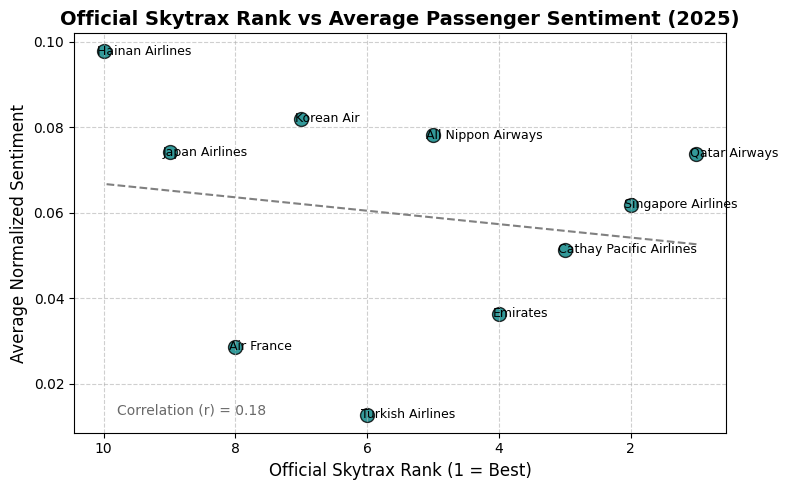

In [43]:
# --- Visualization #3: Scatterplot — Official Rank vs Average Sentiment ---

import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Load your dataset
df = pd.read_csv("data/airlines_review_analysis.csv")

# Define Skytrax 2025 Top 10 (official ranks)
skytrax_top10 = [
    "Qatar Airways",
    "Singapore Airlines",
    "Cathay Pacific Airlines",
    "Emirates",
    "All Nippon Airways",
    "Turkish Airlines",
    "Korean Air",
    "Air France",
    "Japan Airlines",
    "Hainan Airlines",
]
official = pd.DataFrame({
    "Airlines": skytrax_top10,
    "Official Rank": range(1, 11)
})

# Compute average sentiment per airline
avg_sent = (
    df.groupby("Airlines", as_index=False)["Normalized Sentiment Score"]
      .mean()
      .rename(columns={"Normalized Sentiment Score": "Avg Sentiment"})
)

# Merge with official rank
merged = pd.merge(official, avg_sent, on="Airlines", how="left").dropna(subset=["Avg Sentiment"])

# Compute correlation between Official Rank and Average Sentiment
corr, pval = pearsonr(merged["Official Rank"], merged["Avg Sentiment"])

# --- Create Scatterplot ---
plt.figure(figsize=(8, 5))
plt.scatter(
    merged["Official Rank"],
    merged["Avg Sentiment"],
    color="teal",
    s=100,
    alpha=0.8,
    edgecolor="black"
)

# Add regression trendline
z = np.polyfit(merged["Official Rank"], merged["Avg Sentiment"], 1)
p = np.poly1d(z)
plt.plot(merged["Official Rank"], p(merged["Official Rank"]), color="gray", linestyle="--", linewidth=1.5)

# Annotate airline names
for i, row in merged.iterrows():
    plt.text(
        row["Official Rank"] + 0.1,
        row["Avg Sentiment"],
        row["Airlines"],
        fontsize=9,
        va="center"
    )

# Invert X-axis so Rank 1 (best) appears on left
plt.gca().invert_xaxis()

# Labels and title
plt.title("Official Skytrax Rank vs Average Passenger Sentiment (2025)", fontsize=14, fontweight="bold")
plt.xlabel("Official Skytrax Rank (1 = Best)", fontsize=12)
plt.ylabel("Average Normalized Sentiment", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)

# Display correlation in subtitle
plt.text(
    9.8, merged["Avg Sentiment"].min(),
    f"Correlation (r) = {corr:.2f}",
    fontsize=10, color="dimgray"
)

plt.tight_layout()
plt.savefig("visualisations/04_scatter_official_rank_vs_sentiment.png", dpi=150)
plt.show()


C:\Users\sherm\AppData\Local\Temp\ipykernel_15428\3344329311.py:41: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(


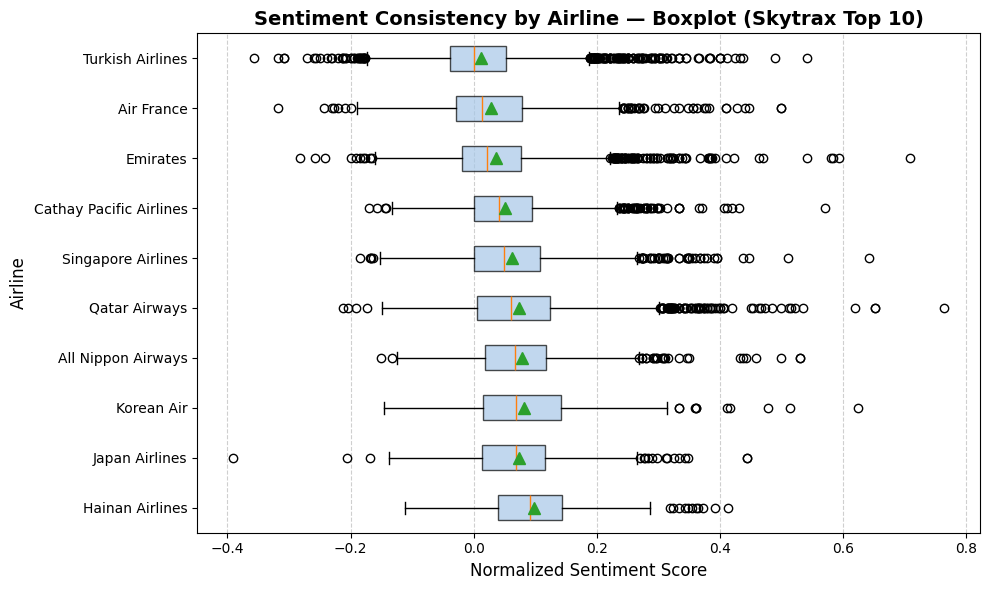

In [44]:
# --- Visualization: Boxplot — Sentiment Consistency by Airline (Skytrax Top 10) ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load processed dataset
df = pd.read_csv("data/airlines_review_analysis.csv")

# Skytrax 2025 Top 10 list (updated version)
skytrax_top10 = [
    "Qatar Airways",
    "Singapore Airlines",
    "Cathay Pacific Airlines",
    "Emirates",
    "All Nippon Airways",
    "Turkish Airlines",
    "Korean Air",
    "Air France",
    "Japan Airlines",
    "Hainan Airlines",
]

# Filter dataset to include only the top 10 airlines and drop missing sentiment scores
dft = df[df["Airlines"].isin(skytrax_top10)].copy()
dft = dft.dropna(subset=["Normalized Sentiment Score"])

# Order airlines by median sentiment (high → low)
order = (
    dft.groupby("Airlines")["Normalized Sentiment Score"]
       .median()
       .sort_values(ascending=False)
       .index.tolist()
)

# Prepare data in order
data_by_airline = [dft.loc[dft["Airlines"] == a, "Normalized Sentiment Score"].values for a in order]

# --- Create Boxplot ---
plt.figure(figsize=(10, 6))
box = plt.boxplot(
    data_by_airline,
    vert=False,                    # horizontal orientation
    labels=order,
    showmeans=True,
    patch_artist=True
)

# Style: soft blue boxes with green mean markers
for patch in box['boxes']:
    patch.set_facecolor("#A7C7E7")
    patch.set_alpha(0.7)
for mean in box['means']:
    mean.set(marker="^", color="green", markersize=8)

# Aesthetics
plt.title("Sentiment Consistency by Airline — Boxplot (Skytrax Top 10)", fontsize=14, fontweight="bold")
plt.xlabel("Normalized Sentiment Score", fontsize=12)
plt.ylabel("Airline", fontsize=12)
plt.grid(axis="x", linestyle="--", alpha=0.6)

# Save and display
plt.tight_layout()
plt.savefig("visualisations/05_boxplot_sentiment_consistency.png", dpi=150)
plt.show()


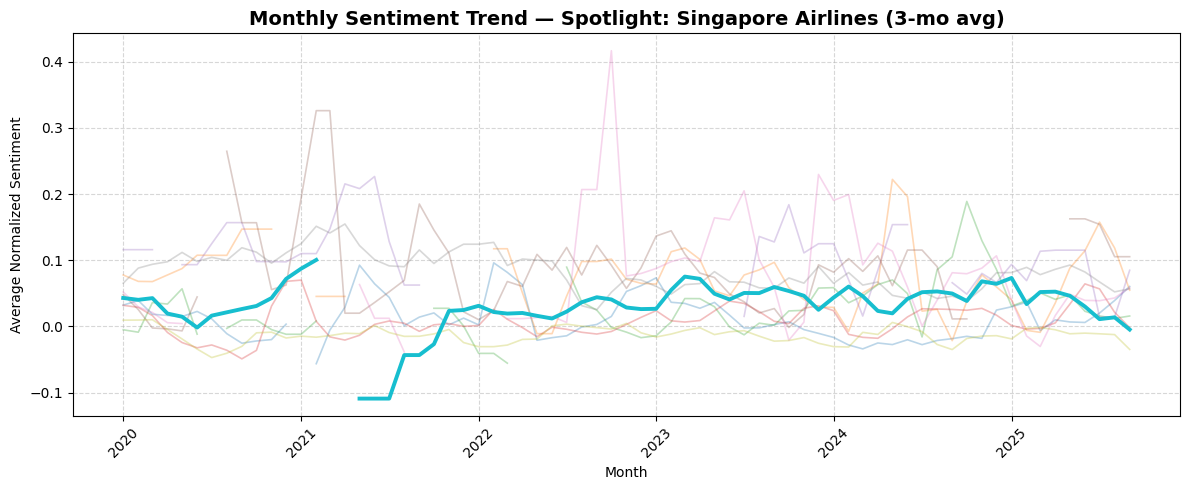

In [45]:
# --- Monthly Sentiment: Spotlight One Airline vs Others (overlay) ---

import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("data/airlines_review_analysis.csv")
df["Date Published"] = pd.to_datetime(df["Date Published"], errors="coerce")

skytrax_top10 = [
    "Qatar Airways",
    "Singapore Airlines",
    "Cathay Pacific Airlines",
    "Emirates",
    "All Nippon Airways",
    "Turkish Airlines",
    "Korean Air",
    "Air France",
    "Japan Airlines",
    "Hainan Airlines",
]

focus_airline = "Singapore Airlines"   # <- change this to spotlight any airline
start = "2020-01-01"

mask = (df["Airlines"].isin(skytrax_top10)) & df["Date Published"].notna()
mask &= df["Date Published"] >= pd.to_datetime(start)
dft = df.loc[mask, ["Date Published","Airlines","Normalized Sentiment Score"]].dropna()

dft["Month"] = dft["Date Published"].dt.to_period("M").dt.to_timestamp()
m = (dft.groupby(["Month","Airlines"])["Normalized Sentiment Score"]
        .mean().reset_index())
wide = m.pivot(index="Month", columns="Airlines", values="Normalized Sentiment Score").sort_index()
wide_sm = wide.rolling(window=3, min_periods=1).mean()

plt.figure(figsize=(12, 5))

# Plot others in light grey
for col in wide_sm.columns:
    if col == focus_airline: 
        continue
    plt.plot(wide_sm.index, wide_sm[col], linewidth=1.2, alpha=0.3)

# Spotlight the chosen airline
if focus_airline in wide_sm.columns:
    plt.plot(wide_sm.index, wide_sm[focus_airline], linewidth=2.8)

plt.title(f"Monthly Sentiment Trend — Spotlight: {focus_airline} (3-mo avg)", fontsize=14, fontweight="bold")
plt.xlabel("Month"); plt.ylabel("Average Normalized Sentiment")
plt.grid(True, linestyle="--", alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"visualisations/06_trend_spotlight_{focus_airline.replace(' ','_')}.png", dpi=150)
plt.show()


In [46]:
# --- Keyword Maps: TF-IDF Top Terms per Airline (Positive vs Negative) ---
import re
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

df = pd.read_csv("data/airlines_review_analysis.csv").dropna(subset=["Text Content Lower Case","Normalized Sentiment Score","Airlines"]).copy()

skytrax_top10 = [
    "Qatar Airways",
    "Singapore Airlines",
    "Cathay Pacific Airlines",
    "Emirates",
    "All Nippon Airways",
    "Turkish Airlines",
    "Korean Air",
    "Air France",
    "Japan Airlines",
    "Hainan Airlines",
]

def basic_clean(s: str) -> str:
    s = str(s).lower()
    s = re.sub(r"[^a-z\s']", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

df["clean"] = df["Text Content Lower Case"].map(basic_clean)

# Simple tokenizer for TF-IDF
def tokenizer(s):
    return [w for w in s.split() if len(w) > 2]

# Vectorizer with domain stopwords baked in
domain_stop = {
    'flight','flights','airline','airlines','plane','travel','seat','seats',
    'singapore','qatar','emirates','air','airways','japan','korean','turkish','france','hainan',
    'nippon','cathay','pacific','review','reviews','service' # keep/remove as you wish
}
vectorizer = TfidfVectorizer(tokenizer=tokenizer, stop_words='english', min_df=3)

rows = []
for airline in skytrax_top10:
    sub = df[df["Airlines"] == airline]
    for label, mask in [("Positive", sub["Normalized Sentiment Score"] > 0),
                        ("Negative", sub["Normalized Sentiment Score"] < 0)]:
        docs = sub.loc[mask, "clean"].tolist()
        # Filter out domain words manually
        docs = [" ".join([w for w in d.split() if w not in domain_stop]) for d in docs]
        if len(docs) < 5:  # not enough text to compute TF-IDF robustly
            rows.append([airline, label, "(insufficient data)"])
            continue
        X = vectorizer.fit_transform(docs)
        terms = vectorizer.get_feature_names_out()
        # Average TF-IDF per term across docs
        avg_scores = X.mean(axis=0).A1
        top_idx = avg_scores.argsort()[-12:][::-1]  # top 12 terms
        top_terms = [terms[i] for i in top_idx]
        rows.append([airline, label, ", ".join(top_terms)])

# Present as a tidy table
tfidf_table = pd.DataFrame(rows, columns=["Airline", "Polarity", "Top Terms"]).sort_values(["Airline","Polarity"])
print(tfidf_table.to_string(index=False))

# Optional: save to CSV for your appendix
tfidf_table.to_csv("visualisations/keyword_map_tfidf_top10.csv", index=False)


c:\Users\sherm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


                Airline Polarity                                                                                          Top Terms
             Air France Negative             paris, luggage, hours, time, food, cdg, class, business, airport, staff, told, economy
             Air France Positive                   good, paris, food, cdg, crew, time, economy, cabin, class, business, staff, nice
     All Nippon Airways Negative           ana, food, class, tokyo, time, business, economy, japanese, cabin, staff, inflight, crew
     All Nippon Airways Positive                      ana, good, food, tokyo, cabin, crew, economy, time, class, staff, meal, great
Cathay Pacific Airlines Negative                  hong, kong, economy, hours, class, food, time, staff, business, crew, meal, cabin
Cathay Pacific Airlines Positive                  good, kong, hong, economy, food, class, cabin, time, business, crew, great, staff
               Emirates Negative       dubai, staff, time, hours, crew, food

This calculates the mean normalized sentiment score for each airline and visualizes the results using a horizontal bar chart.

This generates a boxplot to compare the spread and distribution of normalized sentiment scores across different airlines.

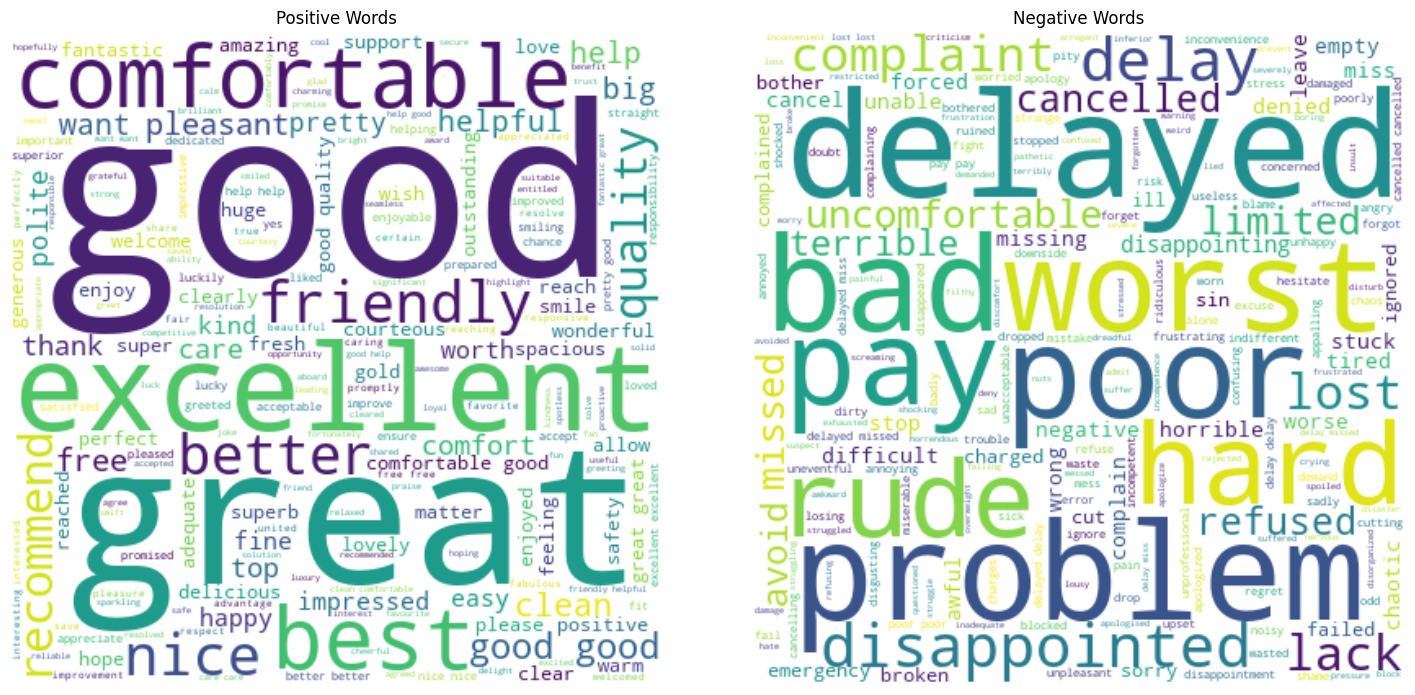

In [47]:
from wordcloud import WordCloud

# Initialize lists to hold positive and negative words
positive_words = []
negative_words = []

# Iterate through each sentence in the DataFrame
for sentence in df['Text Content Lower Case']:
    words = sentence.split()  # Split sentence into words
    
    for word in words:
        score = afinn_dict.get(word, 0)  # Get the sentiment score of the word
        
        if score > 0:
            positive_words.append(word)  # Positive word
        elif score < 0:
            negative_words.append(word)  # Negative word

# Join the positive and negative words into single strings
positive_text = ' '.join(positive_words)
negative_text = ' '.join(negative_words)

# Create subplots for both positive and negative word clouds
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

# Create the positive word cloud
positive_wc = WordCloud(width=400, height=400, background_color="white").generate(positive_text)
axes[0].imshow(positive_wc, interpolation='bilinear')
axes[0].set_title("Positive Words")
axes[0].axis('off')

# Create the negative word cloud
negative_wc = WordCloud(width=400, height=400, background_color="white").generate(negative_text)
axes[1].imshow(negative_wc, interpolation='bilinear')
axes[1].set_title("Negative Words")
axes[1].axis('off')

plt.tight_layout()
plt.show()

### Arbitrary-Length Span

Find the most positive and most negative contiguous sentence spans (any length) and return the exact sentences that compose each span.

In [48]:
# arbitrary-length segments
from math import inf

def kadane_with_indices(arr):
    if not arr:
        return 0, -1, -1
    best_sum = -inf
    cur_sum = 0
    best_l = best_r = cur_l = 0
    for i, x in enumerate(arr):
        if cur_sum <= 0:
            cur_sum = x
            cur_l = i
        else:
            cur_sum += x
        if cur_sum > best_sum:
            best_sum, best_l, best_r = cur_sum, cur_l, i
    return best_sum, best_l, best_r

def best_paragraph_span(text, afinn_dict):
    sents = [s.strip() for s in sent_tokenize(text or "") if s.strip()]
    if not sents:
        return None, None

    sent_scores = [calculate_sentiment_score(s, afinn_dict) for s in sents]

    # most positive span
    pos_sum, pos_l, pos_r = kadane_with_indices(sent_scores)

    # most negative span 
    neg_sum_neg, neg_l, neg_r = kadane_with_indices([-x for x in sent_scores])
    neg_sum = -neg_sum_neg

    pos_span = {
        "text": " ".join(sents[pos_l:pos_r+1]),
        "score": float(pos_sum),
        "start": int(pos_l),
        "end": int(pos_r),
        "sentences": sents[pos_l:pos_r+1],
    }
    neg_span = {
        "text": " ".join(sents[neg_l:neg_r+1]),
        "score": float(neg_sum),
        "start": int(neg_l),
        "end": int(neg_r),
        "sentences": sents[neg_l:neg_r+1],
    }
    return pos_span, neg_span

In [49]:
MONTHS = ['January','February','March','April','May','June',
          'July','August','September','October','November','December']
MONTH_ORDER = {m:i for i,m in enumerate(MONTHS)}

def best_overall_airline(df_group, text_col, afinn_dict):
    """Find best + and - spans inside one group of rows (airline or airline×year×month)."""
    best_pos, best_neg = {"score": -inf}, {"score": inf}
    pos_meta = neg_meta = None

    for idx, r in df_group.iterrows():
        pos, neg = best_paragraph_span(r[text_col], afinn_dict) 

        if pos and pos["score"] > best_pos["score"]:
            best_pos = pos
            pos_meta = {"row": idx, "name": r.get("Name"), "rating": r.get("Rating"),
                        "date": r.get("Date Published"), "full_review": r.get(text_col)}

        if neg and neg["score"] < best_neg["score"]:
            best_neg = neg
            neg_meta = {"row": idx, "name": r.get("Name"), "rating": r.get("Rating"),
                        "date": r.get("Date Published"), "full_review": r.get(text_col)}

    return best_pos, best_neg, pos_meta, neg_meta

def pack_row(common, best_pos, best_neg, pos_meta, neg_meta):
    """Compose a single output row with Pos_/Neg_ blocks."""
    return {
        **common,
        # Most Positive
        "Pos_Text Content": None if pos_meta is None else pos_meta["full_review"],
        "Pos_Most Positive Segment": None if pos_meta is None else best_pos["text"],
        "Pos_Score": None if pos_meta is None else best_pos["score"],
        "Pos_Start of Sentence": None if pos_meta is None else best_pos["start"],
        "Pos_End of Sentence": None if pos_meta is None else best_pos["end"],
        "Pos_Name": None if pos_meta is None else pos_meta["name"],
        "Pos_Rating": None if pos_meta is None else pos_meta["rating"],
        "Pos_Published Date": None if pos_meta is None else pos_meta["date"],
        # Most Negative
        "Neg_Text Content": None if neg_meta is None else neg_meta["full_review"],
        "Neg_Most Negative Segment": None if neg_meta is None else best_neg["text"],
        "Neg_Score": None if neg_meta is None else best_neg["score"],
        "Neg_Start of Sentence": None if neg_meta is None else best_neg["start"],
        "Neg_End of Sentence": None if neg_meta is None else best_neg["end"],
        "Neg_Name": None if neg_meta is None else neg_meta["name"],
        "Neg_Rating": None if neg_meta is None else neg_meta["rating"],
        "Neg_Published Date": None if neg_meta is None else neg_meta["date"],
    }

def rename_block(df, prefix):
    """Rename Pos_/Neg_ columns to presentation names."""
    mapping = {
        f"{prefix}_Text Content": "Text Content",
        f"{prefix}_Most { 'Positive' if prefix=='Pos' else 'Negative' } Segment": 
            f"Most { 'Positive' if prefix=='Pos' else 'Negative' } Segment",
        f"{prefix}_Score": "Score",
        f"{prefix}_Start of Sentence": "Start of Sentence",
        f"{prefix}_End of Sentence": "End of Sentence",
        f"{prefix}_Name": "Name",
        f"{prefix}_Rating": "Rating",
        f"{prefix}_Published Date": "Date Published",
    }
    return df.rename(columns=mapping)

def build_overall(df, afinn_dict, text_col="Text Content", group_col="Airlines"):
    rows = []
    for airline, g in df.groupby(group_col):
        best_pos, best_neg, pos_meta, neg_meta = best_overall_airline(g, text_col, afinn_dict)
        rows.append(pack_row({"Airlines": airline}, best_pos, best_neg, pos_meta, neg_meta))
    out = pd.DataFrame(rows).sort_values("Airlines").reset_index(drop=True)
    pos = rename_block(out[["Airlines"] + [c for c in out.columns if c.startswith("Pos_")]], "Pos")
    neg = rename_block(out[["Airlines"] + [c for c in out.columns if c.startswith("Neg_")]], "Neg")
    return pos, neg

def build_year_month(df, afinn_dict, text_col="Text Content"):
    work = df.copy()
    work["Date Published"] = pd.to_datetime(work["Date Published"], errors="coerce")
    work["Year"] = work["Date Published"].dt.year
    work["Month Name"] = work["Date Published"].dt.month_name()
    work = work.dropna(subset=["Date Published"])

    rows = []
    for (airline, yr, mname), g in work.groupby(["Airlines", "Year", "Month Name"]):
        best_pos, best_neg, pos_meta, neg_meta = best_overall_airline(g, text_col, afinn_dict)
        rows.append(pack_row({"Airlines": airline, "Year": yr, "Month Name": mname},
                             best_pos, best_neg, pos_meta, neg_meta))

    out = pd.DataFrame(rows)
    if not out.empty:
        out = out.sort_values(
            ["Airlines", "Year", "Month Name"],
            key=lambda col: col.map(MONTH_ORDER) if col.name == "Month Name" else col
        ).reset_index(drop=True)

    pos = rename_block(out[["Airlines","Year","Month Name"] + [c for c in out.columns if c.startswith("Pos_")]], "Pos")
    neg = rename_block(out[["Airlines","Year","Month Name"] + [c for c in out.columns if c.startswith("Neg_")]], "Neg")
    return pos, neg

def safe_sheet(name, maxlen=31):
    """Excel-safe sheet name (<=31 chars, no / \ : ? * [ ])"""
    name = re.sub(r'[:\\/?*\[\]]', ' ', str(name)).strip()
    name = re.sub(r'\s+', ' ', name)
    return name[:maxlen]

# overall results tabs
overall_pos, overall_neg = build_overall(df, afinn_dict)

# yearly/monthly tabs
monthly_pos, monthly_neg = build_year_month(df, afinn_dict)

out_path = "airline_arbitrary_length.xlsx"
with pd.ExcelWriter(out_path, engine="openpyxl", mode="w", datetime_format="yyyy-mm-dd") as w:
    overall_pos.to_excel(w, sheet_name=safe_sheet("Overall Most Positive"), index=False)
    overall_neg.to_excel(w, sheet_name=safe_sheet("Overall Most Negative"), index=False)
    monthly_pos.to_excel(w, sheet_name=safe_sheet("Monthly Positive"), index=False)
    monthly_neg.to_excel(w, sheet_name=safe_sheet("Monthly Negative"), index=False)

print(f"Exported to {out_path}")

Exported to airline_arbitrary_length.xlsx


# 7. Web Application (Flask)

In [ ]:
app = Flask(__name__, template_folder='templates')


'''
To present segmentation, replace 'Text Content' with 'Text Content Segmented'
'''
 

df = pd.read_csv('data/airlines_review_analysis.csv')

from nltk.tokenize import sent_tokenize

# Apply AFINN sentiment analysis
#df["sentiment_score"] = df["Text Content"].apply(
#    lambda x: normalize_score(
#        calculate_sentiment_score(str(x), afinn_dict),
#        len(str(x).split())
#    )
#)

# Convert 'Date' column to datetime to facilitate month selection
df['Date Published'] = pd.to_datetime(df['Date Published'])

#list of months in order
order_of_months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
# Extract available airlines and months for the dropdowns
airlines = df['Airlines'].unique().tolist()
months = sorted(df['Date Published'].dt.month_name().unique().tolist(), key=lambda x: order_of_months.index(x))



@app.route('/', methods=['GET', 'POST'])
def index():
    selected_airline = None
    selected_month = None
    t_reviews = []
    b_reviews = []
    positive_window = None
    negative_window = None
    arb_pos = None
    arb_neg = None
    top_airlines = []  # For top airlines across all months
    top_airlines_month = []  # For top airlines based on the selected month

    if request.method == 'POST':
        selected_airline = request.form.get('airline')
        selected_month = request.form.get('month')

        # ** If "All" is selected for month, show top airlines across all months **
        if selected_month == 'All':
            # Calculate top 3 airlines across all months (no filtering by month)
            avg_scores_all = df.groupby('Airlines')['Normalized Sentiment Score'].mean()
            top_airlines = avg_scores_all.sort_values(ascending=False).head(3).items()

            # Show reviews for all airlines if "All" is selected for the airline filter
            if selected_airline == 'All' or selected_airline is None:
                filtered_df = df  # Show all reviews if no specific airline is selected
            else:
                filtered_df = df[df['Airlines'] == selected_airline]  # Filter for the selected airline only

        else:
            # ** If a specific month is selected, show reviews for that month **

            # If "All Airlines" is selected, just filter by the month and don't filter by airline
            if selected_airline == 'All' or selected_airline is None:
                filtered_df = df[df['Date Published'].dt.month_name() == selected_month]
            else:
                # Filter reviews for the selected airline and the selected month
                filtered_df = df[(df['Airlines'] == selected_airline) & 
                                (df['Date Published'].dt.month_name() == selected_month)]

            # Calculate top 3 airlines for the selected month (if specific month is selected)
            monthly_data = df[df['Date Published'].dt.month_name() == selected_month]
            avg_scores_month = monthly_data.groupby('Airlines')['Normalized Sentiment Score'].mean()
            top_airlines_month = avg_scores_month.sort_values(ascending=False).head(3).items()

        # Sort reviews by sentiment score for top and bottom reviews
        top_reviews_df = filtered_df.sort_values(by='Sentiment Score', ascending=False)
        bottom_reviews_df = filtered_df.sort_values(by='Sentiment Score', ascending=True)

        top_reviews = top_reviews_df.head(3)
        bottom_reviews = bottom_reviews_df.head(3)

        # Convert reviews to list format for template rendering
        t_reviews = top_reviews[['Most Positive Senctence', 'Sentiment Score', 'Airlines', 'Text Content']].values.tolist()
        b_reviews = bottom_reviews[['Most Negative Senctence', 'Sentiment Score', 'Airlines', 'Text Content']].values.tolist()

        # Sliding window analysis for positive and negative text segments
        #all_text = ' '.join(filtered_df['Text Content'].dropna().astype(str).tolist())
        #pos, neg = sliding_window_analysis_words(all_text, afinn_dict, window_size=10)  

        #positive_window = pos  # {'paragraph': ..., 'score': ...}
        #negative_window = neg

    return render_template('index.html', airlines=airlines, months=months, t_reviews=t_reviews, b_reviews=b_reviews, selected_airline=selected_airline, selected_month=selected_month, positive_window=positive_window,
        negative_window=negative_window, pos_segment=arb_pos, neg_segment=arb_neg, top_airlines=top_airlines,
        top_airlines_month=top_airlines_month)


if __name__ == "__main__":
    app.run(debug=True, host='127.0.0.1', port=5002, use_reloader=False)


 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5002
Press CTRL+C to quit
